In [1]:
import pandas as pd
import numpy as np
from osprey.config import Config
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from os.path import join

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
frac_min, frac_max = 0.005, 1
fractions = [x for x in np.logspace(np.log10(frac_min), np.log10(frac_max), 5)]
result_dirs = ['data/{:05.1f}pc'.format(x*100) for x in fractions]

all_dfs = []
for i, result_dir in enumerate(result_dirs): 
    df = Config(join(result_dir, 'config.yaml')).trial_results()
    df['data_fraction'] = fractions[i]
    all_dfs.append(df)
    
df = pd.concat(all_dfs)
# i = 0
# result_dir = result_dirs[i]
# df = Config(join(result_dir, 'config-shuffle.yaml')).trial_results()
# df['data_fraction'] = fractions[i]

Loading config file:     data/000.5pc/config.yaml...
Loading trials database: sqlite:///osprey-trials.db...
Loading config file:     data/001.9pc/config.yaml...
Loading trials database: sqlite:///osprey-trials.db...
Loading config file:     data/007.1pc/config.yaml...
Loading trials database: sqlite:///osprey-trials.db...
Loading config file:     data/026.6pc/config.yaml...
Loading trials database: sqlite:///osprey-trials.db...
Loading config file:     data/100.0pc/config.yaml...
Loading trials database: sqlite:///osprey-trials.db...


In [3]:
df.head()
df = df.loc[df['project_name']=='shuffle', :]

In [4]:
df.head()
df.tail()
df.reset_index(inplace=True)
df.shape

(7500, 19)

In [5]:
df = df.loc[:, ['parameters', 'test_scores', 'train_scores', 'data_fraction']]

In [6]:
static_params = df.loc[0, 'parameters']
static_params

{'cluster__max': 1.2,
 'cluster__min': -1.2,
 'cluster__n_bins_per_feature': 10,
 'msm__connectivity': 'largest',
 'msm__count_mode': 'sliding',
 'msm__dt_traj': '1 step',
 'msm__lag': 25,
 'msm__maxerr': 1e-08,
 'msm__maxiter': 1000000,
 'msm__mincount_connectivity': '1/n',
 'msm__reversible': True,
 'msm__score_k': 2,
 'msm__score_method': 'vamp1',
 'msm__sparse': False,
 'msm__statdist_constraint': None}

In [7]:
variables = ['msm__score_k', 'msm__score_method', 'cluster__n_bins_per_feature']
for variable in variables: 
    df[variable] = df['parameters'].apply(lambda x: x[variable])
del df['parameters']

In [8]:
for x in ['test', 'train']:
    df[x+'_scores_std'] = df[x+'_scores'].apply(lambda x: np.std(x))
    df[x+'_scores_median'] = df[x+'_scores'].apply(lambda x: np.median(x))
    del df[x+'_scores']

In [9]:
df['t2_fraction'] = df['data_fraction'].apply(lambda x: '{:4.2f}'.format(x*10))
df['t2_fraction'].unique()

array(['0.05', '0.19', '0.71', '2.66', '10.00'], dtype=object)

In [10]:

df.rename(columns={'msm__score_k': 'k', 'msm__score_method': 'method','cluster__n_bins_per_feature': 'clusters', 
                  'test_scores_median': 'MedCV', 'test_scores_std': 'CV_err'}, 
         inplace=True)
df.head()


,data_fraction,k,method,clusters,CV_err,MedCV,train_scores_std,train_scores_median,t2_fraction
0,0.005,2,vamp1,10,0.003679,1.970459,0.003328,1.977300,0.05
1,0.005,2,vamp2,10,0.009459,1.954530,0.009858,1.948016,0.05
2,0.005,2,vampe,10,0.069833,1.829806,0.007373,1.945905,0.05
3,0.005,3,vamp1,10,0.010953,2.765954,0.015193,2.772744,0.05
4,0.005,3,vamp2,10,0.029915,2.589220,0.032197,2.591849,0.05


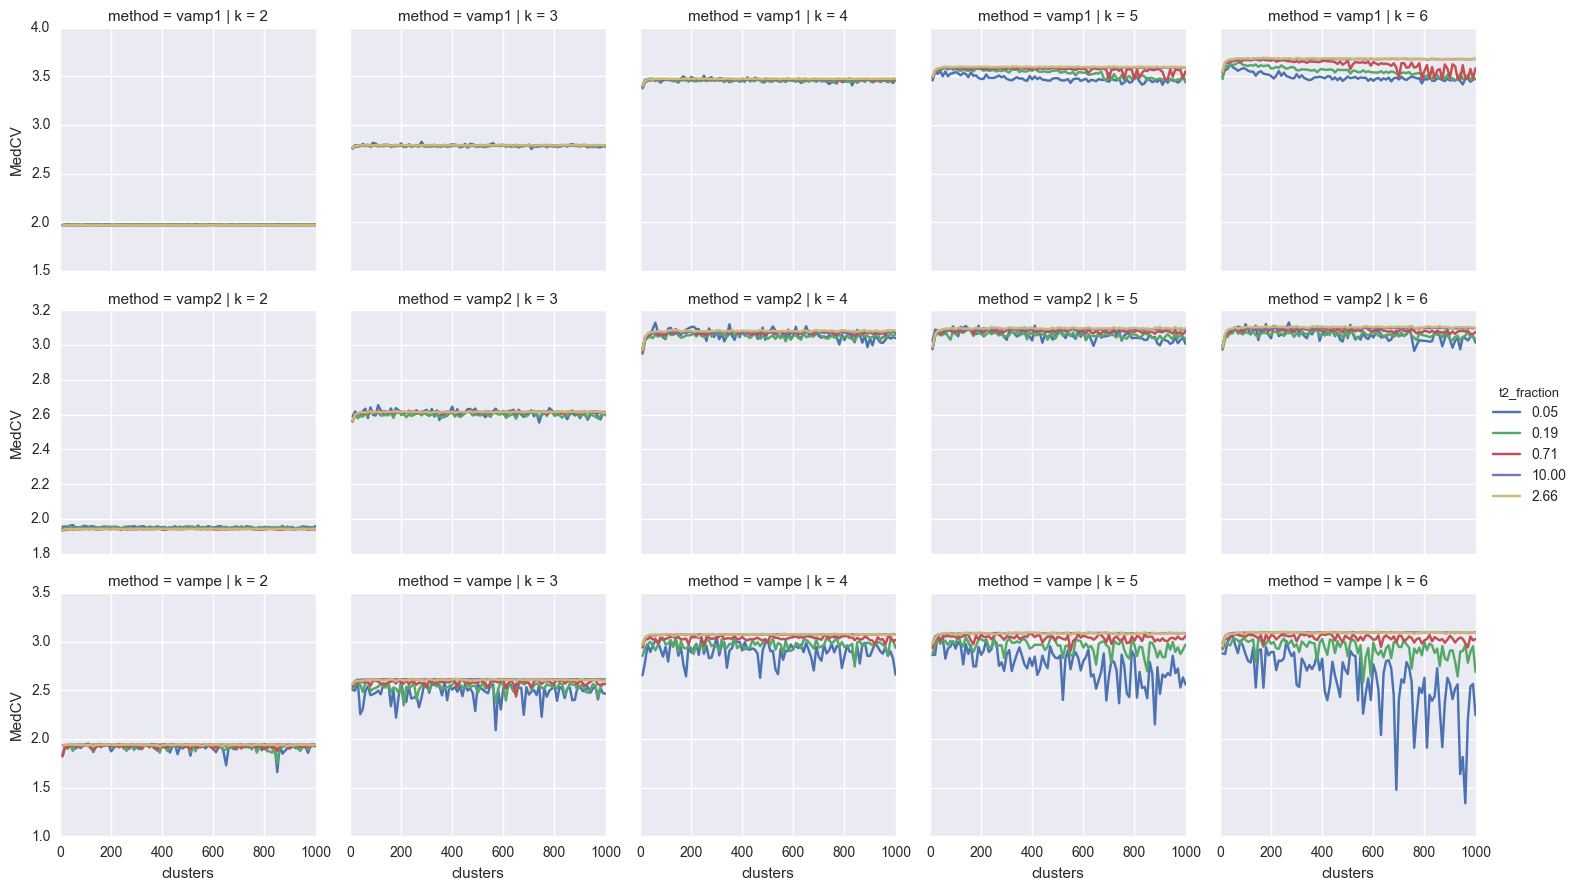

In [11]:
# cols = sns.color_palette('colorblind')
g = sns.FacetGrid(data=df, row='method', col='k', hue='t2_fraction', sharey='row')
g.map(plt.plot, 'clusters', 'MedCV', alpha=1).add_legend()
# g.map(plt.plot, 'clusters', 'train_scores_mean', alpha=1, color=cols[1])

In [12]:
best_idx = df.groupby(['data_fraction',  
                       'method', 'k'])['MedCV'].transform(max) == df['MedCV']

best_df = df.loc[best_idx, :].sort_values(by=['data_fraction',  'method', 'k'])
best_df.head()

,data_fraction,k,method,clusters,CV_err,MedCV,train_scores_std,train_scores_median,t2_fraction
30,0.005,2,vamp1,30,0.002805,1.981463,0.003178,1.972475,0.05
408,0.005,3,vamp1,280,0.035767,2.826051,0.028691,2.764272,0.05
366,0.005,4,vamp1,250,0.030479,3.504578,0.027704,3.453209,0.05
54,0.005,5,vamp1,40,0.030907,3.554596,0.030544,3.600176,0.05
57,0.005,6,vamp1,40,0.022972,3.626593,0.023442,3.690757,0.05


## Choosing M

In [13]:
df.loc[df['k']==4, :].head()

,data_fraction,k,method,clusters,CV_err,MedCV,train_scores_std,train_scores_median,t2_fraction
6,0.005,4,vamp1,10,0.028828,3.399093,0.023742,3.399425,0.05
7,0.005,4,vamp2,10,0.046026,2.981422,0.047419,3.001739,0.05
8,0.005,4,vampe,10,0.256823,2.654272,0.026200,2.999480,0.05
21,0.005,4,vamp1,20,0.025012,3.460883,0.025911,3.439837,0.05
22,0.005,4,vamp2,20,0.044251,3.048747,0.032043,3.077133,0.05


In [14]:
methods = df['method'].unique()
t2_fracs = df['t2_fraction'].unique()


In [15]:
best_idx = df.groupby(['data_fraction',  
                       'method', 'k'])['MedCV'].transform(max) == df['MedCV']

best_df = df.loc[best_idx, :].sort_values(by=['data_fraction',  'method', 'k'])
best_df.head()

,data_fraction,k,method,clusters,CV_err,MedCV,train_scores_std,train_scores_median,t2_fraction
30,0.005,2,vamp1,30,0.002805,1.981463,0.003178,1.972475,0.05
408,0.005,3,vamp1,280,0.035767,2.826051,0.028691,2.764272,0.05
366,0.005,4,vamp1,250,0.030479,3.504578,0.027704,3.453209,0.05
54,0.005,5,vamp1,40,0.030907,3.554596,0.030544,3.600176,0.05
57,0.005,6,vamp1,40,0.022972,3.626593,0.023442,3.690757,0.05


-----2----
-----3----
-----4----
-----5----
-----6----


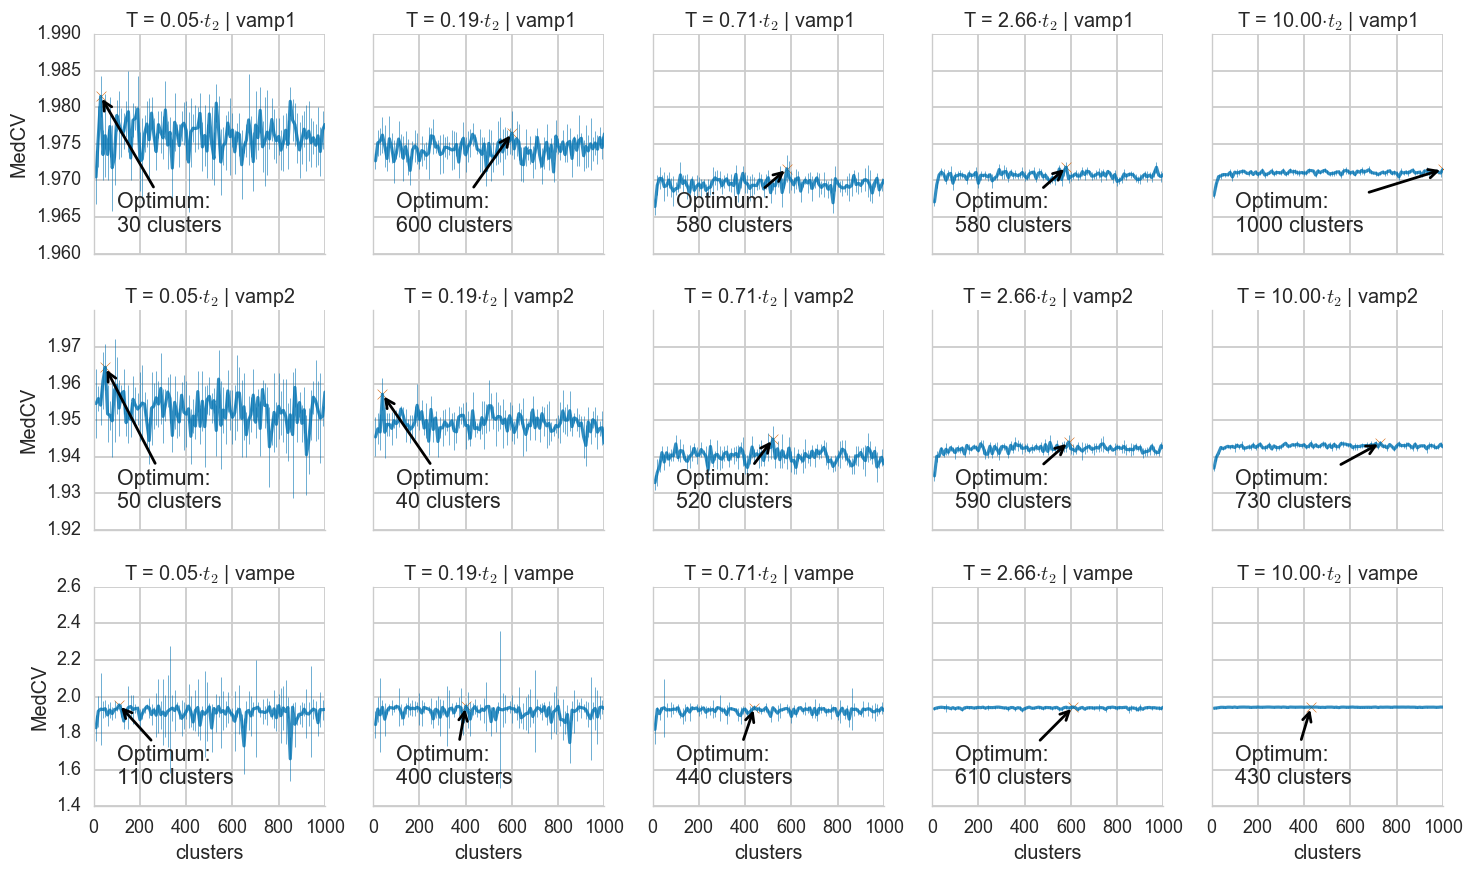

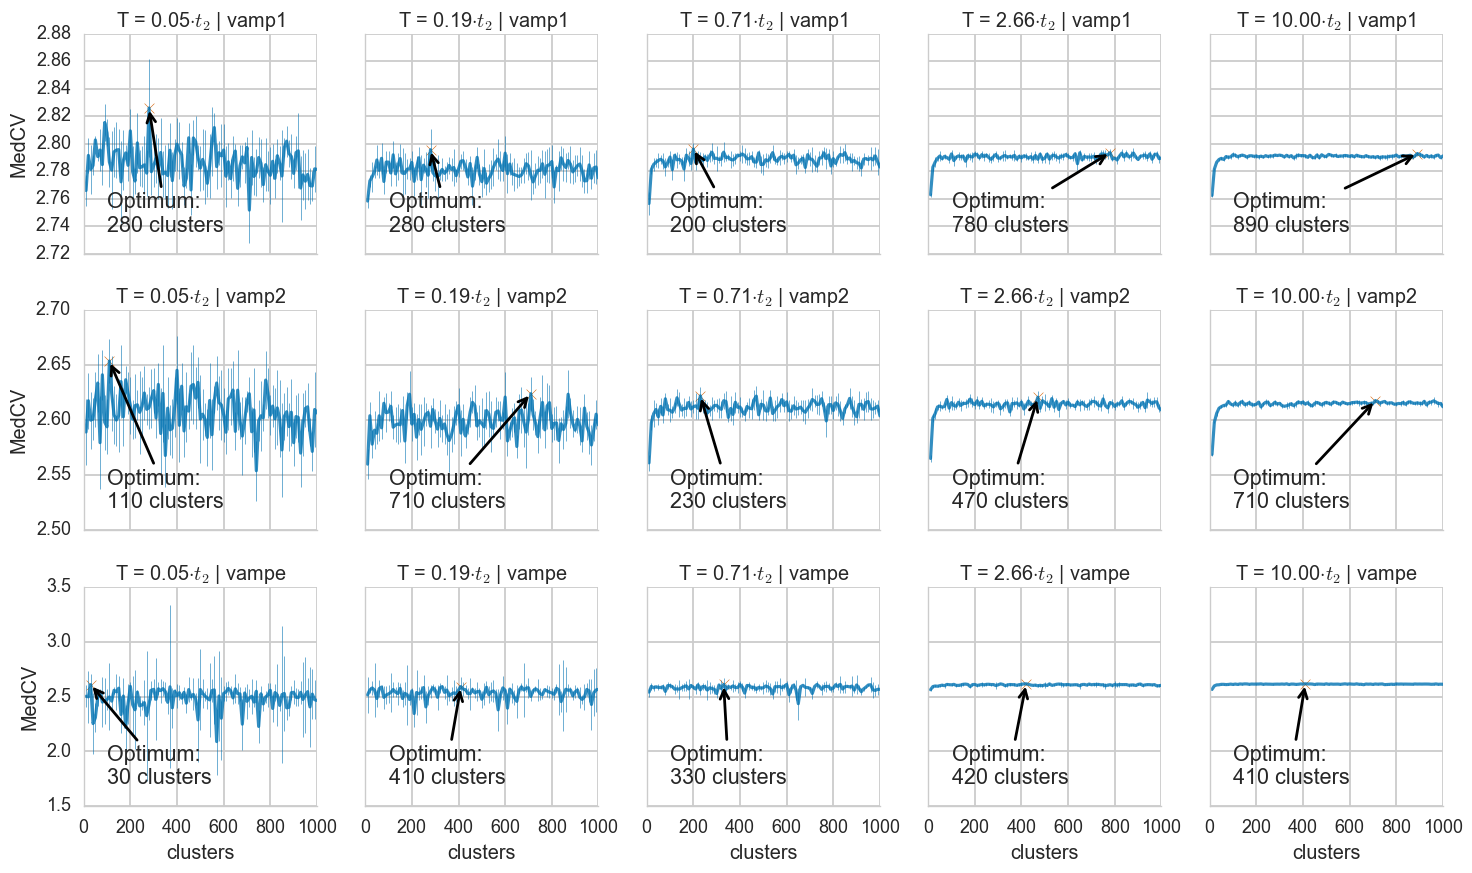

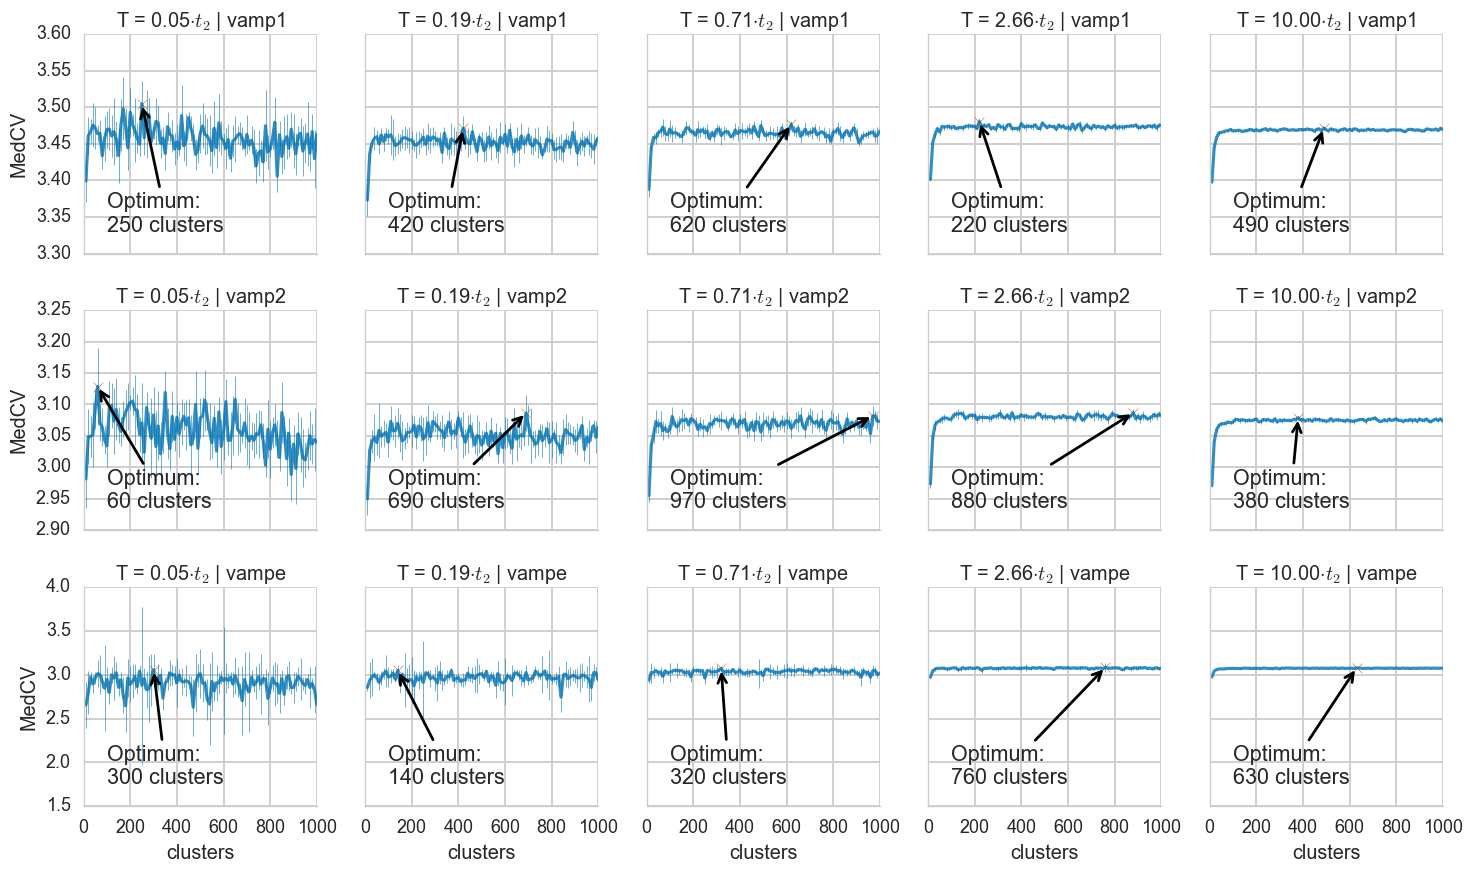

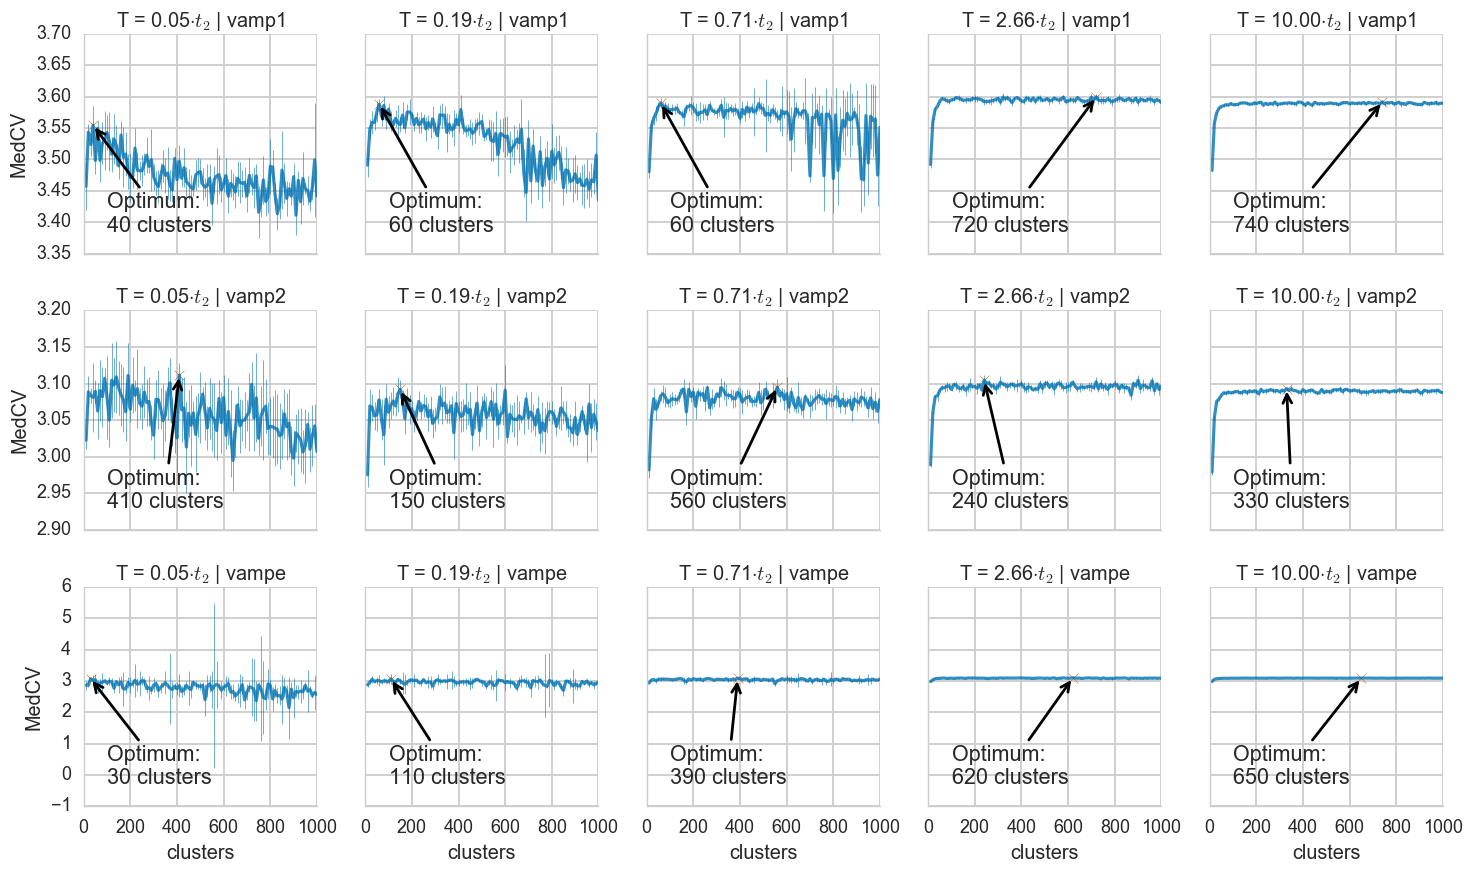

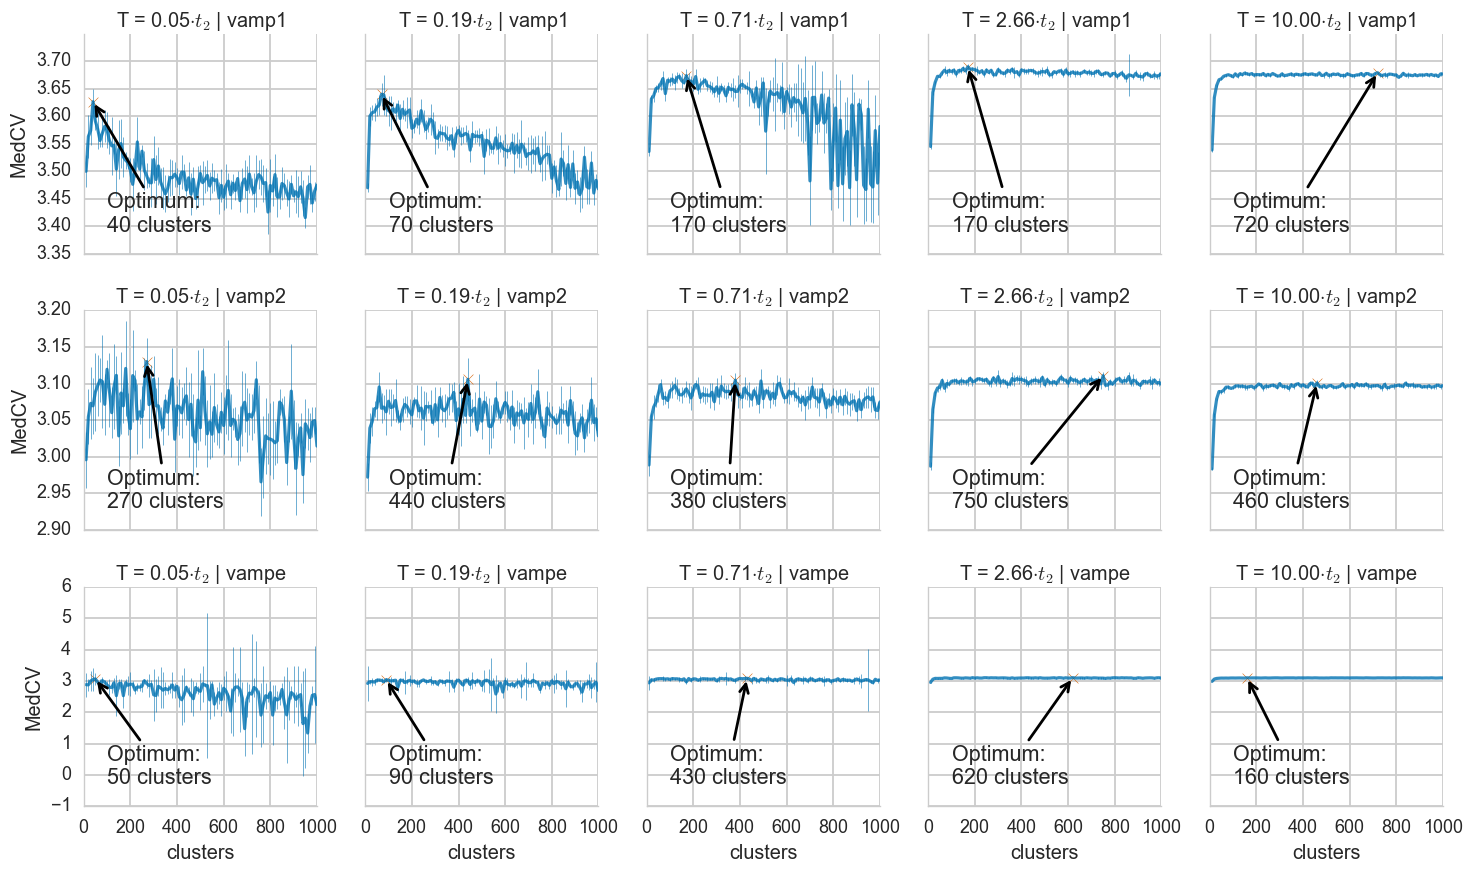

In [17]:
for k in range(2,7):
    print('-----{}----'.format(k))
    df_sample = df.loc[df['k']==k, :]
    best_df_sample = best_df.loc[df['k']==k, :]
    cols = sns.color_palette('colorblind', 3)


    with sns.plotting_context('talk', font_scale=1):
        sns.set_style('whitegrid')
        g = sns.FacetGrid(data=df_sample,  col='t2_fraction', row='method', col_order=t2_fracs,
                          row_order=methods, sharey='row')
        g.map(plt.errorbar, 'clusters', 'MedCV', 'CV_err', 
              alpha=0.8, color=cols[0], elinewidth=.5)
    #     g.map(plt.errorbar, 'clusters', 'test_scores_mean', 
    #           alpha=0.8, color=cols[0])

        g.set_titles('T = {col_name}$ \cdot t_2$ | {row_name}' )
        g.set(xlim=(0,1000))
        for i in range(g.axes.shape[0]):
            for j in range(g.axes.shape[1]):
                ax = g.axes[i][j]
                idx = (best_df_sample['method']==methods[i]) & (best_df_sample['data_fraction']==fractions[j])

                x = best_df_sample.loc[idx, 'clusters']
                y = best_df_sample.loc[idx, 'MedCV']
                ax.scatter(x, y, c=cols[-1], marker='x', s=50)

                label = 'Optimum:\n{} clusters'.format(x.values[0])
                ax.annotate(label,
                        xy=(x, y), xycoords='data',
                        xytext=(.1, .1),  textcoords='axes fraction', 
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="arc3", linewidth=2),
                        )
        plt.tight_layout()
        plt.savefig('figures/osprey_T_vs_m_k{}.png'.format(k), transparent=True)
# g.map(plt.errorbar, 'cluster__n_bins_per_feature', 'train_scores_mean','train_scores_std',  alpha=1, color=cols[1])

## Choosing K

In [ ]:
best_idx = df.groupby(['data_fraction',  
                       'method', 'clusters'])['MedCV'].transform(max) == df['MedCV']

best_df = df.loc[best_idx, :].sort_values(by=['data_fraction',  'method', 'clusters'])
best_df.head()

In [ ]:
for m in [100, 200, 400, 600]: #",200,300,400,500]:
    
    df_sample = df.loc[df['clusters']==m, :]
    best_df_sample = best_df.loc[df['clusters']==m, :]
    cols = sns.color_palette('colorblind', 3)
    
    with sns.plotting_context('talk', font_scale=1):
        sns.set_style('whitegrid')
        g = sns.FacetGrid(data=df_sample,  col='t2_fraction', row='method', row_order=methods,
                          col_order=t2_fracs, sharey='row')

        g.map(plt.errorbar, 'k', 'MedCV', 'CV_err',
              alpha=1, ls='', marker='o')

        g.set_titles('T = {col_name}$ \cdot t_2$ | {row_name}' )
        g.set(xlim=(1,7))
        plt.tight_layout()
        
        
        for i in range(g.axes.shape[0]):
            for j in range(g.axes.shape[1]):
                ax = g.axes[i][j]
                idx = (best_df_sample['method']==methods[i]) & (best_df_sample['data_fraction']==fractions[j])

                x = best_df_sample.loc[idx, 'k']
                y = best_df_sample.loc[idx, 'MedCV']
                ax.scatter(x, y, c=cols[-1], marker='x', s=50)

                label = 'Optimum:\n k = {}'.format(x.values[0])
                ax.annotate(label,
                        xy=(x, y), xycoords='data',
                        xytext=(.7, .1),  textcoords='axes fraction', 
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="arc3", linewidth=2),
                        )

    plt.savefig('figures/osprey_T_vs_k_m{}.png'.format(m), transparent=True)

# g.map(plt.errorbar, 'cluster__n_bins_per_feature', 'train_scores_mean','train_scores_std',  alpha=1, color=cols[1])

In [ ]:
# best_df_sample = best_df.loc[df['m']==k, :]
df.head()

In [ ]:
best_idx = df.groupby(['t2_fraction',  
                       'method'])['MedCV'].transform(max) == df['MedCV']

best_df = df.loc[best_idx, ['method', 'data_fraction','t2_fraction', 'k', 'clusters', 'MedCV', 'CV_err']].sort_values(by=[ 'method', 'data_fraction'])
best_df

In [ ]:
with sns.plotting_context('talk', font_scale=1):
    sns.set_style('whitegrid')
    g = sns.FacetGrid(data=best_df, col='t2_fraction', col_order=t2_fracs, row='method', row_order=methods)
    g.map(plt.scatter, 'k', 'clusters', s=100,).add_legend()
    g.set_titles('T = {col_name}$ \cdot t_2$ | {row_name}' )
    g.set(ylim=(0,1000), xlim=(1,7))
    plt.tight_layout()
    plt.savefig('figures/osprey_best.png',transparent=True)